### Download the data

In [1]:
from sqlalchemy import create_engine
import pandas as pd

from research.utils.data_access_utils import RDSAccessUtils


In [2]:
import json, os

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [3]:
query = """SELECT pen_id, annotation_state_id, base_key, url_key, left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata, annotation FROM prod.crop_annotation WHERE (service_id=1) 
 AND (annotation_state_id IN (3, 4, 6, 7)) AND captured_at > '2021-03-09'"""

production_data = rds_access_utils.extract_from_database(query)

In [4]:
production_data['site_id'] = production_data['base_key'].str.split('/').apply(lambda ps: ps[1])

### Filter the metadata to only include analyzed images. 

In [5]:
id2state = {
    3:'QA',
    4:'SKIPPED_ANN',
    6:'SKIPPED_QA',
    7:'VERIFIED'
}

production_data['state'] = production_data['annotation_state_id'].apply(lambda id: id2state[id] if id in id2state else None)
production_data = production_data[production_data['state'].notnull()]
production_data['state'].value_counts()

QA             22444
VERIFIED       20337
SKIPPED_ANN    19400
SKIPPED_QA      1786
Name: state, dtype: int64

In [6]:
qa_accepts = production_data[production_data['state'] == 'VERIFIED']

In [7]:
pen_counts = qa_accepts.site_id.value_counts()

In [8]:
import pandas as pd

all_pens = list(production_data.site_id.unique())
naccepts_per_pen = 200
sampled_accepts = pd.DataFrame([], columns=qa_accepts.columns)

for s in all_pens:
    this_pen_accepts = qa_accepts[qa_accepts['site_id'] == s]
    this_pen_count = 0 if s not in pen_counts else pen_counts[s]
    this_pen_sample = this_pen_accepts.sample(min(naccepts_per_pen, len(this_pen_accepts)))
    sampled_accepts = pd.concat([sampled_accepts, this_pen_sample])
# sampled_accepts.site_id.value_counts()

In [9]:
# sampled_accepts.site_id.value_counts().sum()

In [10]:
pen_counts = sampled_accepts['site_id'].value_counts()
# pen_counts

In [11]:
cogito_skips = production_data[production_data['state'] == 'SKIPPED_ANN']

In [12]:
import pandas as pd

all_pens = list(production_data.site_id.unique())
nskips_per_pen = int(round((len(qa_accepts)*2)/len(all_pens), 0))
sampled_skips = pd.DataFrame([], columns=cogito_skips.columns)

for p in all_pens:
    this_pen_skips = cogito_skips[cogito_skips['site_id'] == p]
    this_pen_count = 0 if p not in pen_counts else pen_counts[p]
    this_pen_sample = this_pen_skips.sample(min(this_pen_count, len(this_pen_skips)))
    sampled_skips = pd.concat([sampled_skips, this_pen_sample])
# sampled_skips.pen_id.value_counts()

In [13]:
import pandas as pd

#eval_data = pd.concat([sampled_accepts, sampled_skips])
eval_data = pd.concat([sampled_accepts, sampled_skips])
# eval_data

### Download the images

In [14]:
def get_url(row):
    if isinstance(row['left_crop_url'], str):
        return row['left_crop_url']
    elif isinstance(row['right_crop_url'], str):
        return row['right_crop_url']
    else:
        assert False
    

eval_data['url'] = eval_data.apply(get_url, axis=1)
eval_data['url']

36505    https://aquabyte-crops.s3.eu-west-1.amazonaws....
52186    https://aquabyte-crops.s3.eu-west-1.amazonaws....
39614    https://aquabyte-crops.s3.eu-west-1.amazonaws....
61566    https://aquabyte-crops.s3.eu-west-1.amazonaws....
44383    https://aquabyte-crops.s3.eu-west-1.amazonaws....
                               ...                        
19640    https://aquabyte-crops.s3.eu-west-1.amazonaws....
24733    https://aquabyte-crops.s3.eu-west-1.amazonaws....
20963    https://aquabyte-crops.s3.eu-west-1.amazonaws....
58549    https://aquabyte-crops.s3.eu-west-1.amazonaws....
22819    https://aquabyte-crops.s3.eu-west-1.amazonaws....
Name: url, Length: 4723, dtype: object

In [15]:
import os

production_eval_img_dir = '/root/data/skip-classifier/test-images/2021-03-16'

os.makedirs(production_eval_img_dir, exist_ok = True)

def get_local_path(url):
    name = '_PATHSEP_'.join(url.split('/')[3:])
    return os.path.join(production_eval_img_dir, name)

eval_data['local_path'] = eval_data.url.apply(get_local_path)
# eval_data.local_path.iloc[:10].tolist()

In [16]:
import os

already_downloaded = os.listdir(production_eval_img_dir)

In [17]:
already_downloaded = [os.path.join(production_eval_img_dir, url) for url in already_downloaded]

In [18]:
len(already_downloaded)

8423

In [19]:
import requests
import os
import shutil

def download_image(_row, exclude_images=[]):
    _, row = _row
    
    url, local_path = row['url'], row['local_path']
    if local_path not in exclude_images:
        response = requests.get(url, stream=True)
        with open(local_path, 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
    return local_path 

In [20]:
production_data_images = eval_data[~eval_data.url.duplicated()]
# production_data_images.info()

In [21]:
need_to_download = production_data_images[~production_data_images['local_path'].isin(already_downloaded)]
len(need_to_download)

3052

In [22]:
need_to_download

,pen_id,annotation_state_id,base_key,url_key,left_crop_url,right_crop_url,left_crop_metadata,right_crop_metadata,annotation,site_id,state,url,local_path
36505,159,7,environment=production/site-id=96/pen-id=159/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{'width': 3898, 'height': 2243, 'x_coord': 197...","{'width': 4095, 'height': 2223, 'x_coord': 0, ...","{'isPartial': True, 'visibleBodySections': ['D...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
52186,211,7,environment=production/site-id=96/pen-id=211/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 3960, 'height': 2056, 'x_coord': 135...","{'lice': [{'width': 34, 'xCrop': 1159, 'yCrop'...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
39614,210,7,environment=production/site-id=96/pen-id=210/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 3890, 'height': 1636, 'x_coord': 205...","{'lice': [{'width': 51, 'xCrop': 2901, 'yCrop'...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
61566,159,7,environment=production/site-id=96/pen-id=159/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 4095, 'height': 1418, 'x_coord': 0, ...",None,"{'lice': [{'width': 54, 'xCrop': 2496, 'yCrop'...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
44383,210,7,environment=production/site-id=96/pen-id=210/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{'width': 3602, 'height': 2006, 'x_coord': 493...","{'width': 4082, 'height': 1981, 'x_coord': 13,...","{'lice': [{'width': 40, 'xCrop': 859, 'yCrop':...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
41560,159,7,environment=production/site-id=96/pen-id=159/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 3798, 'height': 1514, 'x_coord': 297...","{'lice': [{'width': 15, 'xCrop': 1177, 'yCrop'...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
37857,211,7,environment=production/site-id=96/pen-id=211/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,https://aquabyte-crops.s3.eu-west-1.amazonaws....,"{'width': 3524, 'height': 1445, 'x_coord': 571...","{'width': 4095, 'height': 1520, 'x_coord': 0, ...","{'lice': [{'width': 185, 'xCrop': 1212, 'yCrop...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
45252,211,7,environment=production/site-id=96/pen-id=211/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 4095, 'height': 2009, 'x_coord': 0, ...","{'lice': [{'width': 58, 'xCrop': 1363, 'yCrop'...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
46689,210,7,environment=production/site-id=96/pen-id=210/d...,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,https://aquabyte-crops.s3.eu-west-1.amazonaws....,None,"{'width': 3842, 'height': 1883, 'x_coord': 253...","{'lice': [{'width': 50, 'xCrop': 1975, 'yCrop'...",site-id=96,VERIFIED,https://aquabyte-crops.s3.eu-west-1.amazonaws....,/root/data/skip-classifier/test-images/2021-03...
41767,2

In [23]:
from tqdm.notebook import tqdm
from functools import partial
from multiprocessing import Pool

# tqdm.pandas()

# .progress_apply(partial(), axis=1)
num_processes = 20

pool = Pool(num_processes)

list(tqdm(pool.imap(download_image, need_to_download.iterrows()), total=len(need_to_download)))

['/root/data/skip-classifier/test-images/2021-03-16/environment=production_PATHSEP_site-id=96_PATHSEP_pen-id=159_PATHSEP_date=2021-03-09_PATHSEP_hour=08_PATHSEP_at=2021-03-09T08:16:12.618727000Z_PATHSEP_left_frame_crop_252_753_4096_3000.jpg',
 '/root/data/skip-classifier/test-images/2021-03-16/environment=production_PATHSEP_site-id=96_PATHSEP_pen-id=211_PATHSEP_date=2021-03-14_PATHSEP_hour=10_PATHSEP_at=2021-03-14T10:29:59.288353000Z_PATHSEP_right_frame_crop_196_970_4096_3000.jpg',
 '/root/data/skip-classifier/test-images/2021-03-16/environment=production_PATHSEP_site-id=96_PATHSEP_pen-id=210_PATHSEP_date=2021-03-10_PATHSEP_hour=11_PATHSEP_at=2021-03-10T11:23:46.711313000Z_PATHSEP_right_frame_crop_220_1362_4096_3000.jpg',
 '/root/data/skip-classifier/test-images/2021-03-16/environment=production_PATHSEP_site-id=96_PATHSEP_pen-id=159_PATHSEP_date=2021-03-15_PATHSEP_hour=08_PATHSEP_at=2021-03-15T08:31:36.615082000Z_PATHSEP_left_frame_crop_0_1556_4096_3000.jpg',
 '/root/data/skip-classifi

Process ForkPoolWorker-1:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-15:
Process ForkPoolWorker-19:
Process ForkPoolWorker-5:
Process ForkPoolWorker-14:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-17:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Process ForkPoolWorker-16:
Process ForkPoolWorker-2:
Process ForkPoolWorker-10:
Process ForkPoolWorker-20:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/user/miniconda/envs/py36/lib/python3.6/multiprocessing/pool.py",

In [24]:
downloaded_production_data = production_data_images#[production_data_images['local_path'].isin(already_downloaded)]
# downloaded_production_data.info()

### Run classifier on these images

In [ ]:
# NEW_MODEL_NAME = 'testing123__2021-01-19__08-57-40'
# NEW_MODEL_PATH = os.path.join('/root/data/sid/needed_datasets/skip_classifier_checkpoints/', NEW_MODEL_NAME)
# #SPLITS_NAME = '07-14-2020_stratify_hour_partialfish.json'
# #SPLIT_PATH = os.path.join('/root/data/sid/needed_data/skip_classifier_datasets/splits', SPLITS_NAME)
# BEST_EPOCH = 'epoch_1'
# metric_path = os.path.join(NEW_MODEL_PATH, BEST_EPOCH, 'train', 'metrics.json')

In [79]:
# import sys
# sys.path.append('/root/skip_classifier/')

from model_new import ImageClassifier
# MultilabelClassifier
# help(MultilabelClassifier)

In [182]:
ACCEPT_LABEL, SKIP_LABEL = 'ACCEPT', 'SKIP'
import torch

device = 0
# metric_path = os.path.join(NEW_MODEL_PATH, BEST_EPOCH, 'train', 'metrics.json')
# print(json.load(open(metric_path)))
path = os.path.join('/root/data/skip-classifier/models', '2021-03-16', 'model.pt')
# new_model = MultilabelClassifier(savename=None, num_labels=2)
new_model = ImageClassifier(['ACCEPT', 'SKIP'], device, savename=None)
new_model.load_state_dict(torch.load(path))
new_model.to(device)
new_model.cuda()
new_model.eval()

ImageClassifier(
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [37]:
# downloaded_production_data.iloc[:5]

In [183]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn')

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from loader_new import TRANSFORMS
import cv2
from torch.nn.functional import sigmoid

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def image_to_array(file_path):
    # Read an image with OpenCV
    image = cv2.imread(file_path)

    # By default OpenCV uses BGR color space for color images,
    # so we need to convert the image to RGB color space.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = TRANSFORMS['pad'](image=image)['image']
    return image 

def multilabel_preds(cuda_inputs, model):
    outputs = model(cuda_inputs)
    preds = sigmoid(outputs)
    cpu_outputs = preds.detach().cpu().numpy()
    return cpu_outputs[0]

def regular_preds(cuda_inputs, model):
    preds = model(cuda_inputs)
    cpu_outputs = preds.detach().cpu().numpy()
    return cpu_outputs[0][0]

def get_predictions(image, model, pred_fn):
    cuda_inputs = torch.unsqueeze(image.to(device), dim=0)
    with torch.set_grad_enabled(False):
        return pred_fn(cuda_inputs, model)
    
def get_predictions_raw(image, model, pred_fn):
    cuda_inputs = torch.unsqueeze(image.to(device), dim=0)
    return model(cuda_inputs)
    
# def path2newmodelpredictions(_row):
#     _, row = _row
#     file_path = row['local_path']
#     return get_predictions(image_to_array(file_path), new_model, multilabel_preds)

# def path2newmodelpredictions(file_path):
#     return get_predictions(image_to_array(file_path), new_model, multilabel_preds)
def path2newmodelpredictions(file_path):
    return get_predictions_raw(image_to_array(file_path), new_model, regular_preds)
output = downloaded_production_data['local_path'].iloc[2380:2470].apply(path2newmodelpredictions)

In [ ]:
# OLD_MODEL_NAME = 'bodypart_model_multi__2020-09-28__00-36-53'
# OLD_MODEL_PATH = os.path.join('/root/data/sid/needed_datasets/skip_classifier_checkpoints/', OLD_MODEL_NAME)
# #SPLITS_NAME = '07-14-2020_stratify_hour_partialfish.json'
# #SPLIT_PATH = os.path.join('/root/data/sid/needed_data/skip_classifier_datasets/splits', SPLITS_NAME)
# BEST_EPOCH = 'epoch_0'
# metric_path = os.path.join(OLD_MODEL_PATH, BEST_EPOCH, 'train', 'metrics.json')
# open(metric_path).read()

In [ ]:
# from train import ACCEPT_LABEL, SKIP_LABEL
# import torch
# from model import ImageClassifier

# device = 0
# metric_path = os.path.join(OLD_MODEL_PATH, BEST_EPOCH, 'train', 'metrics.json')
# print(json.load(open(metric_path)))
# path = os.path.join(OLD_MODEL_PATH, BEST_EPOCH, 'train', 'model.pt')
# old_model = MultilabelClassifier(savename=None, num_labels=5)
# old_model.load_state_dict(torch.load(path))
# old_model.to(device)
# old_model.cuda()
# old_model.eval()

In [35]:
# def path2oldmodelpredictions(file_path):
#     return get_predictions(image_to_array(file_path), old_model, multilabel_preds)

# downloaded_production_data['local_path'].iloc[:5].apply(path2oldmodelpredictions)

NameError: name 'old_model' is not defined

In [30]:
# downloaded_production_data = downloaded_production_data.sort_values('captured_at', ascending=True).head(20000)

In [84]:
downloaded_production_data['production_predicted_accept_prob'] = downloaded_production_data.apply(lambda row:
    row['left_crop_metadata']['quality_score'] if row['left_crop_metadata'] 
    else row['right_crop_metadata']['quality_score'], axis=1)

In [85]:
from tqdm.notebook import tqdm

tqdm.pandas()

downloaded_production_data['new_model_predicted_accept_prob'] = downloaded_production_data['local_path'].progress_apply(
    path2newmodelpredictions)

# pool = Pool(num_processes)

# new_model_predicted_accept_prob = list(tqdm(pool.imap(path2newmodelpredictions, downloaded_production_data.iterrows()), total=len(downloaded_production_data)))
# downloaded_production_data['new_model_predicted_accept_prob'] = new_model_predicted_accept_prob


KeyboardInterrupt: 

In [184]:
outputs = torch.cat(list(output.values))
# _, preds = torch.max(outputs, 1)

# accept_label_idx = 1
outputs

tensor([[1.0000e+00, 1.2520e-13],
        [1.0000e+00, 2.3258e-15],
        [1.0000e+00, 6.0422e-08],
        [1.0000e+00, 1.5163e-07],
        [1.0000e+00, 4.4499e-10],
        [1.1773e-06, 1.0000e+00],
        [1.0000e+00, 1.1615e-09],
        [1.0000e+00, 6.8122e-07],
        [9.8300e-01, 1.6998e-02],
        [1.0000e+00, 4.1943e-13],
        [5.0057e-03, 9.9499e-01],
        [9.9985e-01, 1.5196e-04],
        [4.6125e-02, 9.5388e-01],
        [1.0000e+00, 7.3693e-14],
        [1.0000e+00, 2.0570e-10],
        [1.4552e-01, 8.5448e-01],
        [1.0000e+00, 1.0408e-09],
        [1.0000e+00, 1.1065e-08],
        [1.0000e+00, 4.1246e-15],
        [1.0000e+00, 3.3108e-12],
        [1.0000e+00, 8.2657e-10],
        [1.0000e+00, 2.9285e-06],
        [1.0000e+00, 2.8786e-08],
        [1.0000e+00, 3.3452e-09],
        [1.0000e+00, 6.3606e-11],
        [1.0000e+00, 1.2368e-09],
        [9.9990e-01, 1.0006e-04],
        [8.6790e-02, 9.1321e-01],
        [1.0000e+00, 2.5517e-06],
        [9.990

In [185]:
downloaded_production_data['label'].iloc[2380:2420].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [186]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

accept_label_idx = 0

labels = downloaded_production_data['label'].iloc[2380:2470].values

outputs = torch.cat(list(output.values))
_, preds = torch.max(outputs, 1)
preds = preds.cpu().numpy()
preds = preds == accept_label_idx
pred_probs = outputs[:, accept_label_idx]
pred_probs = pred_probs.detach().cpu().numpy()

precision = precision_score(labels, preds)

recall = recall_score(labels, preds)

auc = roc_auc_score(labels, pred_probs)

print(precision, recall, auc)

0.2222222222222222 0.8 0.5753571428571429


In [71]:
downloaded_production_data.iloc[0]

pen_id                                                                            159
annotation_state_id                                                                 7
base_key                            environment=production/site-id=96/pen-id=159/d...
url_key                             https://aquabyte-crops.s3.eu-west-1.amazonaws....
left_crop_url                       https://aquabyte-crops.s3.eu-west-1.amazonaws....
right_crop_url                      https://aquabyte-crops.s3.eu-west-1.amazonaws....
left_crop_metadata                  {'width': 3898, 'height': 2243, 'x_coord': 197...
right_crop_metadata                 {'width': 4095, 'height': 2223, 'x_coord': 0, ...
annotation                          {'isPartial': True, 'visibleBodySections': ['D...
site_id                                                                    site-id=96
state                                                                        VERIFIED
url                                 https://aquabyte-c

In [ ]:
# downloaded_production_data['old_model_predicted_accept_prob'] = downloaded_production_data['local_path'].progress_apply(path2oldmodelpredictions)

In [44]:
downloaded_production_data['new_model_cleaned'] = downloaded_production_data['new_model_predicted_accept_prob'].apply(sum)
# downloaded_production_data['old_model_cleaned'] = downloaded_production_data['old_model_predicted_accept_prob'].apply(sum)

In [45]:
downloaded_production_data.annotation.apply(type).value_counts()

<class 'dict'>        2400
<class 'NoneType'>    2323
Name: annotation, dtype: int64

In [46]:
downloaded_production_data2 = downloaded_production_data[downloaded_production_data['annotation'].apply(type)!=list]


In [47]:
import json
len(downloaded_production_data2)

def get_sections(row):
    ann = row['annotation']

    if row['annotation_state_id'] == 7:
        if ann is None:
            return ['VENTRAL_POSTERIOR',
                     'VENTRAL_ANTERIOR',
                     'DORSAL_POSTERIOR',
                     'DORSAL_ANTERIOR',
                     'HEAD']
        elif ann.get('isPartial', None):
            return ann.get('visibleBodySections', None)
        else:
            return ['VENTRAL_POSTERIOR',
                     'VENTRAL_ANTERIOR',
                     'DORSAL_POSTERIOR',
                     'DORSAL_ANTERIOR',
                     'HEAD']

    else:
        return []
            

downloaded_production_data2['visibleBodySections'] = downloaded_production_data2.apply(get_sections, axis=1)
print(downloaded_production_data2['visibleBodySections'].isnull().sum())
downloaded_production_data2 = downloaded_production_data2[downloaded_production_data2['visibleBodySections'].notnull()]

0


In [49]:
# BODYPART_COLS = ['VENTRAL_POSTERIOR',
#                      'VENTRAL_ANTERIOR',
#                      'DORSAL_POSTERIOR',
#                      'DORSAL_ANTERIOR',
#                      'HEAD']

In [59]:
downloaded_production_data2

for col in BODYPART_COLS:
    downloaded_production_data2[col] = downloaded_production_data2['visibleBodySections'].apply(
        lambda l: col[4:] in l)

In [52]:
# new['site_id'].value_counts()

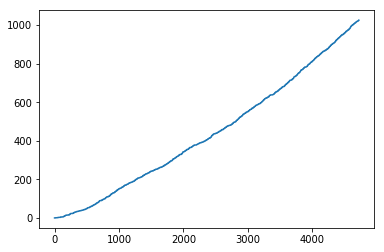

In [60]:
import matplotlib.pyplot as plt

new = downloaded_production_data2.sort_values('new_model_cleaned', ascending=False)
new[BODYPART_COLS] = new[BODYPART_COLS].cumsum()
new['kpi'] = new[BODYPART_COLS].apply(min, axis=1)

# old = downloaded_production_data2.sort_values('old_model_cleaned', ascending=False)
# old[BODYPART_COLS] = old[BODYPART_COLS].cumsum()
# old['kpi'] = old[BODYPART_COLS].apply(min, axis=1)

fig, ax = plt.subplots()
ax.plot(range(len(new)), new['kpi'])
# ax.plot(range(len(old)), old['kpi'])

(0, 500)

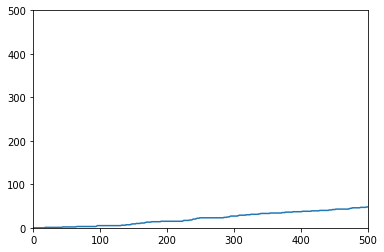

In [61]:
import matplotlib.pyplot as plt

new = downloaded_production_data2.sort_values('new_model_cleaned', ascending=False)
new[BODYPART_COLS] = new[BODYPART_COLS].cumsum()
new['kpi'] = new[BODYPART_COLS].apply(min, axis=1)

# old = downloaded_production_data2.sort_values('old_model_cleaned', ascending=False)
# old[BODYPART_COLS] = old[BODYPART_COLS].cumsum()
# old['kpi'] = old[BODYPART_COLS].apply(min, axis=1)

fig, ax = plt.subplots()
ax.plot(range(len(new)), new['kpi'])
# ax.plot(range(len(old)), old['kpi'])
ax.set_ylim((0, 500))
ax.set_xlim((0, 500))

### Get performance metrics

In [ ]:
downloaded_production_data['state'].value_counts()

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(labels, outputs, title, pen_id=None, skip_reason=None, ax=None):
    if len(labels.unique()) > 1:
        fpr, tpr, thresholds = roc_curve(labels, outputs)
        auc = roc_auc_score(labels, outputs)
        lw = 2
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % auc)
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate (skiprate)')
        ax.set_ylabel('Recall (KPI)')
        ax.set_title(title, size=20)
        ax.legend(loc="lower right")
    else:
        assert False

In [58]:
from loader_new import BODYPART_COLS

BODYPART_COLS

['HAS_VENTRAL_POSTERIOR',
 'HAS_VENTRAL_ANTERIOR',
 'HAS_DORSAL_POSTERIOR',
 'HAS_DORSAL_ANTERIOR',
 'HAS_HEAD']

In [ ]:
downloaded_production_data.columns

In [ ]:
downloaded_production_data['annotation'].apply(type).value_counts()

In [63]:
import json

def get_sections(row):
    ann = row['annotation']

    if row['annotation_state_id'] == 7:
        if ann is None:
            return ['VENTRAL_POSTERIOR',
                     'VENTRAL_ANTERIOR',
                     'DORSAL_POSTERIOR',
                     'DORSAL_ANTERIOR',
                     'HEAD']
        elif isinstance(ann, list):
            print(row)
        elif (not ann['isPartial']):
            return ['VENTRAL_POSTERIOR',
                     'VENTRAL_ANTERIOR',
                     'DORSAL_POSTERIOR',
                     'DORSAL_ANTERIOR',
                     'HEAD']
        else:
            return ann['visibleBodySections']
    else:
        return []
            

downloaded_production_data['visibleBodySections'] = downloaded_production_data.apply(get_sections, axis=1)

In [64]:
for bp_col in BODYPART_COLS:
    downloaded_production_data[bp_col] = downloaded_production_data.visibleBodySections.progress_apply(
        lambda sections: bp_col[4:] in sections)

In [65]:
bodypart_weights = 1/downloaded_production_data[BODYPART_COLS].mean()
bodypart_weights /= bodypart_weights.sum()
bodypart_weights.index = bodypart_weights.index.map(lambda s: s[4:])
normalize_params = {'overall': bodypart_weights.to_dict()}
normalize_params

{'overall': {'VENTRAL_POSTERIOR': 0.24154305248210806,
  'VENTRAL_ANTERIOR': 0.13506589415490838,
  'DORSAL_POSTERIOR': 0.250497819305835,
  'DORSAL_ANTERIOR': 0.15192915076241473,
  'HEAD': 0.22096408329473394}}

In [72]:
# json.dump(normalize_params, open('oct5_bodypart_normalize_params.json', 'w'))

In [ ]:
!pwd

In [77]:
import torch.nn as nn

a = downloaded_production_data.iloc[0]['new_model_predicted_accept_prob']
nn.functional.sigmoid(a)

AttributeError: 'numpy.ndarray' object has no attribute 'sigmoid'

In [74]:
downloaded_production_data.iloc[0]

pen_id                                                                            159
annotation_state_id                                                                 7
base_key                            environment=production/site-id=96/pen-id=159/d...
url_key                             https://aquabyte-crops.s3.eu-west-1.amazonaws....
left_crop_url                       https://aquabyte-crops.s3.eu-west-1.amazonaws....
right_crop_url                      https://aquabyte-crops.s3.eu-west-1.amazonaws....
left_crop_metadata                  {'width': 3898, 'height': 2243, 'x_coord': 197...
right_crop_metadata                 {'width': 4095, 'height': 2223, 'x_coord': 0, ...
annotation                          {'isPartial': True, 'visibleBodySections': ['D...
site_id                                                                    site-id=96
state                                                                        VERIFIED
url                                 https://aquabyte-c

In [73]:
for idx, bp in enumerate(BODYPART_COLS):
    pred_col = bp.replace('HAS_', 'PRED_')
    downloaded_production_data[pred_col] = downloaded_production_data['new_model_predicted_accept_prob'].apply(
        lambda arr: arr[idx])

IndexError: index 2 is out of bounds for axis 0 with size 2

### Cogito accepts

In [67]:
def get_label(state):
    if state == 'VERIFIED':
        return 1 
    elif state == 'SKIPPED_ANN':
        return 0
    else:
        return None
    
downloaded_production_data['label'] = downloaded_production_data['state'].apply(get_label)

In [ ]:
downloaded_production_data['label'].value_counts()

In [187]:
downloaded_production_data['label'].unique()

array([1, 0])

In [69]:
import matplotlib.pyplot as plt

cogito_data = downloaded_production_data[downloaded_production_data['cogito_label'].notnull()]

all_pens = ['overall'] + list(cogito_data.pen_id.unique())
fig, axes = plt.subplots(nrows=len(all_pens), ncols=7, figsize=(30, 5*len(all_pens)))
cogito_data = downloaded_production_data[downloaded_production_data['label'].notnull()]

for pen, ax in zip(all_pens, axes):
    if pen != 'overall':
        this_pen = cogito_data[cogito_data['pen_id'] == pen]
    else:
        this_pen = cogito_data
    if pen == 'overall':
        title1 = 'production'
        title2 = 'fullbody'
    ax[0].set_xlabel(f'pen:{pen}')
    plot_roc(this_pen['label'], this_pen['production_predicted_accept_prob'], ax=ax[0], title=title1)
#     plot_roc(this_pen['label'], this_pen['old_model_predicted_accept_prob'], ax=ax[1], title=title2)
    for i, col in enumerate(BODYPART_COLS):
        if pen == 'overall':
            title = col
        else:
            title = ''
        try:
            plot_roc(this_pen[col], this_pen[col.replace('HAS_', 'PRED_')], ax=ax[i+2], pen_id=pen, title=title)
        except:
            pass

KeyError: 'cogito_label'

In [ ]:
cogito_data['production_predicted_accept_prob']

In [70]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

res = dict()
pen = 'overall'
for pen in all_pens:
    res[pen] = dict()
    if pen != 'overall':
        this_pen = cogito_data[cogito_data['pen_id'] == pen]
    else:
        this_pen = cogito_data
    pred_cols = ['production_predicted_accept_prob', 'old_model_predicted_accept_prob'] + [col.replace('HAS_', 'PRED_') for col in BODYPART_COLS]
    lab_cols = ['label', 'label'] + BODYPART_COLS
    for lab_col, pred_col in zip(lab_cols, pred_cols):
        if len(this_pen[lab_col].unique()) != 1:
            res[pen][pred_col] = roc_auc_score(this_pen[lab_col], this_pen[pred_col])
pd.DataFrame(res).apply(pd.Series, axis=1).T

NameError: name 'cogito_data' is not defined

In [ ]:
def cogito_accept_rate(states):
    if states.isin([3,4]).sum() > 20:
        return (states == 3).sum() / states.isin([3,4]).sum()
    
def cogito_samples(states):
    return states.isin([3, 4]).sum()

def qa_samples(states):
    return states.isin([4, 6, 7]).sum()

def qa_accept_rate(states):
    if states.isin([4,6,7]).sum()> 20:
        return (states == 7).sum() / states.isin([4,6,7]).sum()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

nbins = 20
bins = [0] + [cogito_data['new_model_predicted_accept_prob'].quantile(b/nbins) for b in range(nbins+1)]
cogito_data['score_bucket'] = pd.cut(cogito_data['new_model_predicted_accept_prob'], bins=bins, labels=False)
expected_bins = set(range(nbins+1))

def acceptrate_to_score_hist(data, bins, binmethod='pctile'):
        
    
    scorebin_acceptrates = data.groupby('score_bucket')['annotation_state_id'].aggregate(
        [cogito_accept_rate, qa_accept_rate, cogito_samples, qa_samples])
    missing_bins = set(range(len(bins)-1)) - set(list(scorebin_acceptrates.index))
    #missing_bins = scorebin_acceptrates[scorebin_acceptrates['cogito_accept_rate'].isnull()].index
    for b in missing_bins:
        scorebin_acceptrates.loc[b] = None
        #next_bin = b
        #while (next_bin in missing_bins) and (next_bin <= nbins):
        #    next_bin += 1
        #if next_bin <= nbins:
        #    scorebin_acceptrates.loc[b] = scorebin_acceptrates.loc[next_bin]
        #else:
        #    scorebin_acceptrates.loc[b] = scorebin_acceptrates.loc[max(found_bins)]
    scorebin_acceptrates.sort_index(inplace=True)
    scorebin_acceptrates['cutoff'] = bins[:-1]
    return scorebin_acceptrates
    
fig, ax = plt.subplots()
acceptrate_to_score_hist(cogito_data, bins).plot.bar(y=['cogito_accept_rate'], ax=ax)

In [ ]:
import matplotlib.pyplot as plt

pen_scores = dict()
pen_counts = dict()
all_pens = ['overall'] + list(cogito_data['pen_id'].unique())
fig, axes = plt.subplots(nrows=len(all_pens), figsize=(5, len(all_pens)*5))

for pen_id, ax in zip(all_pens, axes):
    if pen_id != 'overall':
        print(pen_id)
        this_pen = cogito_data[cogito_data['pen_id'] == pen_id]
        print(this_pen)
        rate2scores = acceptrate_to_score_hist(this_pen, bins)
        rate2scores = rate2scores[rate2scores['cogito_samples'] > 20] 
        pen_scores[pen_id] = rate2scores
        if len(pen_scores):
            pen_scores[pen_id].plot.bar(y=['cogito_accept_rate'], ax=ax)
        ax.set_xticks([])
        ax.set_title(f'Pen:{pen_id}')
        ax.set_ylim((0, 1.0))
    else:
        pen_scores[pen_id] = acceptrate_to_score_hist(cogito_data, bins)
        pen_scores[pen_id].plot.bar(y=['cogito_accept_rate'], ax=ax)
        ax.set_xticks([])
        ax.set_title(f'Pen:{pen_id}')
        ax.set_ylim((0, 1.0))

In [ ]:
pen_counts = cogito_data.groupby(['pen_id', 'score_bucket'])['score_bucket'].aggregate('count')
for pen_id in cogito_data['pen_id'].unique():
    print(pen_id)
    print(pen_counts.loc[(pen_id)])

In [ ]:
pen_scores

In [ ]:
import numpy as np

transform_data = dict()

for pen_id in pen_scores:
    cutoffs = pen_scores[pen_id]['cutoff']
    rates = pen_scores[pen_id]['cogito_accept_rate']
    bins = list(sorted([int(bin) for bin in cutoffs.keys()]))
    print(rates)
    transform_data[pen_id] = [(cutoffs[b], rates[b]) for b in bins
                              if not np.isnan(rates[b])]

transform_data

In [ ]:
def postprocess_normscore(data):
    new_data = dict()
    for pen in data:
        if len(data[pen]) < 5:
            continue
        new_data[str(pen)] = []
        cutoffs = [x[0] for x in data[pen]]
        assert cutoffs == sorted(cutoffs)
        rates = [x[1] for x in data[pen]]
        for idx, (cutoff, rate) in enumerate(zip(cutoffs, rates)):
            if idx != 0:
                these_rates = [x[1] for x in new_data[str(pen)]]
                biggest_rate_sofar = max(these_rates[:idx])
            else:
                biggest_rate_sofar = 0.0
            
            if rate is None:      
                rate = biggest_rate_sofar
            if  rate < biggest_rate_sofar:
                rate = biggest_rate_sofar
            
            new_data[str(pen)].append((cutoff, rate))
            
        if new_data[str(pen)][0][0] != 0.0:
            new_data[str(pen)] = [(0, new_data[str(pen)][0][1])] + new_data[str(pen)]
        if new_data[str(pen)][-1][0] != 1.0:
            new_data[str(pen)] = new_data[str(pen)] + [(1.0, new_data[str(pen)][-1][1])]
        if max([x[1] for x in new_data[str(pen)]]) == 0:
               del new_data[str(pen)]
    return new_data
new_data = postprocess_normscore(transform_data) 

In [ ]:
new_data['119']

In [ ]:
json.dump(new_data, open('pen_normalization_aug3_model.json', 'w'))

In [ ]:
!aws s3 ls s3://aquabyte-research/sid/production_models/skip_classifier/08-03-2020/model.py

In [ ]:
!aws s3 cp /root/data/sid/needed_datasets/skip_classifier_checkpoints/08-03-2020_stratify_hour_partialfish_justlice__2020-08-03__01-47-17/epoch_2/val/model.pt s3://aquabyte-research/sid/production_models/skip_classifier/08-03-2020/model.pt

In [ ]:
!aws s3 cp pen_normalization_aug3_model.json s3://aquabyte-research/sid/production_models/skip_classifier/08-03-2020/norm_params.json